<a href="https://colab.research.google.com/github/xqyn/modeling/blob/main/remake_langevin_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

${\displaystyle m{\frac {\mathrm {d} \mathbf {v} }{\mathrm {d} t}}=-\lambda \mathbf {v} +{\boldsymbol {\eta }}\left(t\right).}$

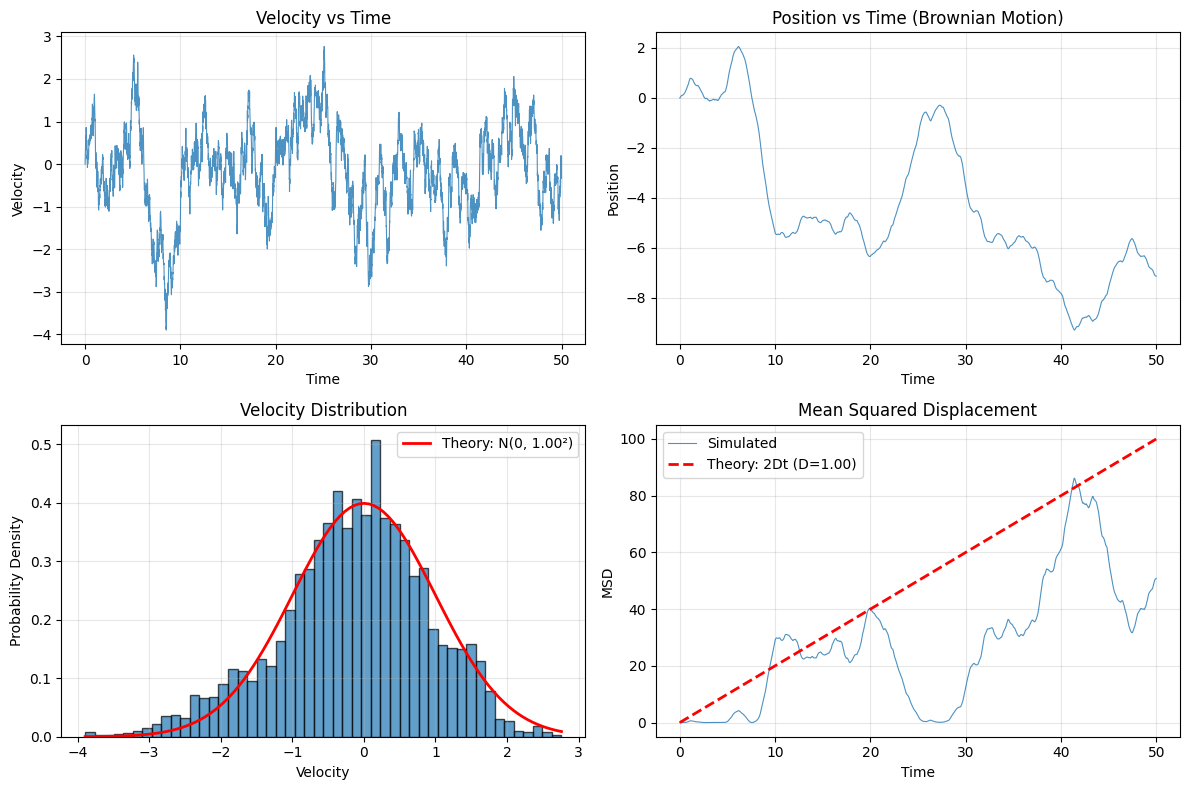

Velocity statistics:
  Mean: -0.1426 (expected: 0)
  Std:  1.0380 (expected: 1.0000)

Position statistics:
  Final position: -7.1280
  MSD at final time: 50.8081
  Theoretical MSD: 99.9800


In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m = 1.0             # mass
gamma = 1.0         # friction coefficient
kB = 1.0            # Boltzmann constant
T = 1.0             # temperature
dt = 0.01           # time step
steps = 5000        # number of steps

# Initialize arrays
v = np.zeros(steps)  # velocity
x = np.zeros(steps)  # position

# Initial conditions (can be modified)
v[0] = 0.0
x[0] = 0.0

# Noise strength (fluctuation-dissipation theorem)
sigma = np.sqrt(2 * gamma * kB * T / m)

# Simulation loop (Euler-Maruyama)
for i in range(steps-1):
    # Random force term (Wiener process increment)
    dW = np.random.randn() * np.sqrt(dt)

    # Update velocity from Langevin equation: dv = -(gamma/m)*v*dt + sigma*dW
    v[i+1] = v[i] - (gamma/m) * v[i] * dt + sigma * dW

    # Update position using updated velocity (more accurate)
    x[i+1] = x[i] + v[i+1] * dt

# Time array for plotting
time = np.arange(steps) * dt

# Plot results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Velocity trajectory
axes[0, 0].plot(time, v, lw=0.8, alpha=0.8)
axes[0, 0].set_title("Velocity vs Time")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Velocity")
axes[0, 0].grid(alpha=0.3)

# Position trajectory
axes[0, 1].plot(time, x, lw=0.8, alpha=0.8)
axes[0, 1].set_title("Position vs Time (Brownian Motion)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Position")
axes[0, 1].grid(alpha=0.3)

# Velocity distribution (should be Gaussian with variance kB*T/m)
axes[1, 0].hist(v, bins=50, density=True, alpha=0.7, edgecolor='black')
theoretical_std = np.sqrt(kB * T / m)
v_range = np.linspace(v.min(), v.max(), 100)
axes[1, 0].plot(v_range,
                1/(np.sqrt(2*np.pi*theoretical_std**2)) * np.exp(-v_range**2/(2*theoretical_std**2)),
                'r-', lw=2, label=f'Theory: N(0, {theoretical_std:.2f}²)')
axes[1, 0].set_title("Velocity Distribution")
axes[1, 0].set_xlabel("Velocity")
axes[1, 0].set_ylabel("Probability Density")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Mean squared displacement (should scale linearly with time)
msd = x**2
axes[1, 1].plot(time, msd, lw=0.8, alpha=0.8, label='Simulated')
# Theoretical MSD for overdamped case: 2*D*t where D = kB*T/gamma
D = kB * T / gamma
axes[1, 1].plot(time, 2 * D * time, 'r--', lw=2, label=f'Theory: 2Dt (D={D:.2f})')
axes[1, 1].set_title("Mean Squared Displacement")
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("MSD")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Velocity statistics:")
print(f"  Mean: {np.mean(v):.4f} (expected: 0)")
print(f"  Std:  {np.std(v):.4f} (expected: {theoretical_std:.4f})")
print(f"\nPosition statistics:")
print(f"  Final position: {x[-1]:.4f}")
print(f"  MSD at final time: {x[-1]**2:.4f}")
print(f"  Theoretical MSD: {2*D*time[-1]:.4f}")

In [128]:
class LangevinSimulator:
  '''
  simulate langevin equation:
    m*dv/dt = -γv + F(x) + ξ(t)
  where:
    - m: mass
    - γ: fiction cofficient
    - F(x): deterministic force
    - ξ(t): random thermal force
  '''

  def __init__(self,
               mass=1.0,
               gamma=1.0,
               temperature=1.0,
               dt=0.01):
    self.m = mass
    self.gamma = gamma
    self.kT = temperature # k_b * T
    self.dt = dt

    # Calculate noise strength from fluctuation-dissipation theorem
    # self.D = np.sqrt(2 * gamma * self.kT * self.m / dt)

    # standard deviation of the noise force
    # # Noise strength (without /dt)
    self.D = np.sqrt(2 * gamma * self.kT)

  def harmonic_force(self, x, k=1.0):
    '''harmonic force: F = -kx'''
    return -k * x

  def double_well_force(self, x, a=1.0, b=1.0):
    '''double-well potential force: F = ax - bx³'''
    return a * x - b * x**3

  def simulate(self,
               n_steps,
               x0=0.0,
               v0=0.0,
               force_func=None,
               **force_params):
    '''
    simulate particle trajectory using Euler-Maruyama method
    '''
    if force_func is None:
      force_func = self.harmonic_force

    # init arrays:
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0], v[0] = x0, v0

    # time evolution:
    for i in range(1, n_steps):

      # # random force (white noise)
      # xi = np.random.normal(0, self.D)

      # # deterministic force
      # F_det = force_func(x[i-1], **force_params)

      # # update velocity: dv = (-γv + F + ξ)/m * dt
      # dv = (-self.gamma * v[i-1] + F_det + xi) / self.m * self.dt
      # v[i] = v[i-1] + dv

      # # update positions: dx = v * dt
      # x[i] = x[i-1] + v[i] * self.dt

      # In loop:
      xi = np.random.normal(0, self.D * np.sqrt(dt))
      F_det = force_func(x[i-1], **force_params)
      dv = (-self.gamma * v[i-1] + F_det + xi) / self.m * dt
      v[i] = v[i-1] + dv
      x[i] = x[i-1] + v[i-1] * dt  # Use v[i-1], not v[i]

    return x, v

In [122]:
print("Langevin Equation Simulator")
print("=" * 50)
print("\nThe Langevin equation describes Brownian motion:")
print("m * dv/dt = -γv + F(x) + ξ(t)")
print("\nwhere:")
print("  - γ: friction coefficient")
print("  - F(x): deterministic force")
print("  - ξ(t): random thermal force")
print("  - Noise strength satisfies: <ξ(t)ξ(t')> = 2γk_BT*m*δ(t-t')")
print("=" * 50)

Langevin Equation Simulator

The Langevin equation describes Brownian motion:
m * dv/dt = -γv + F(x) + ξ(t)

where:
  - γ: friction coefficient
  - F(x): deterministic force
  - ξ(t): random thermal force
  - Noise strength satisfies: <ξ(t)ξ(t')> = 2γk_BT*m*δ(t-t')


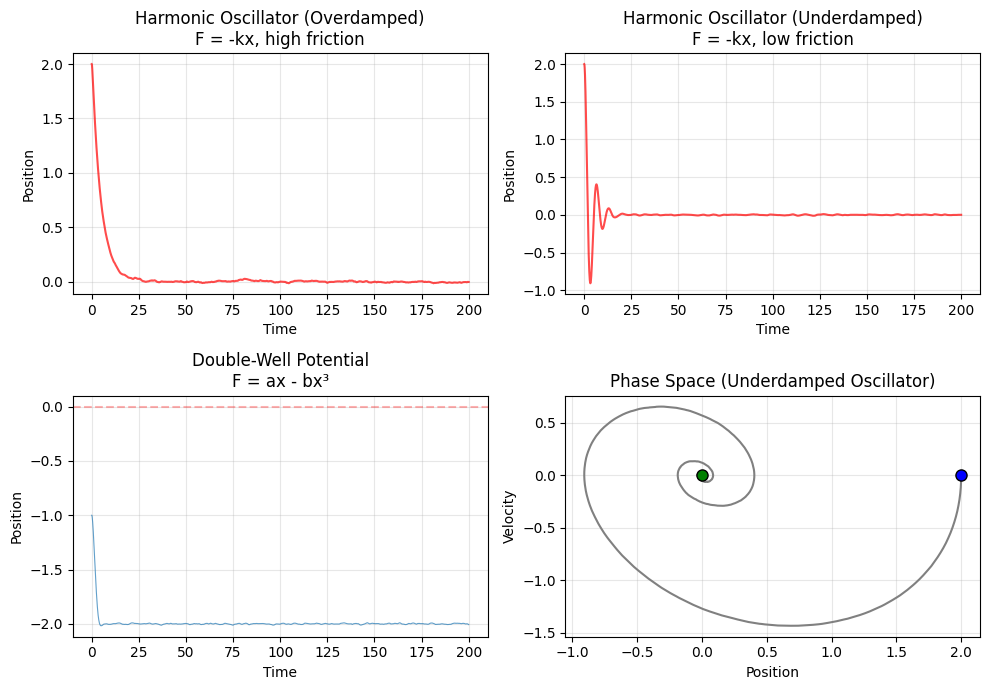

In [129]:
"""Plot multiple trajectories in different potentials"""

fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Simulation parameters
n_steps = 20000
dt = 0.01
time = np.arange(n_steps) * dt

# 1. Harmonic oscillator (overdamped)
sim1 = LangevinSimulator(mass=1.0, gamma=5.0, temperature=0.5, dt=dt)
x1, v1 = sim1.simulate(n_steps,
                       x0=2.0,
                       force_func=sim1.harmonic_force,
                       k=1.0)

axes[0, 0].plot(time, x1, linewidth=1.5, alpha=0.7, color = 'red')
# axes[0, 0].plot(x1, time, linewidth=0.8, alpha=0.7)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Position')
axes[0, 0].set_title('Harmonic Oscillator (Overdamped)\nF = -kx, high friction')
axes[0, 0].grid(True, alpha=0.3)

# 2. Harmonic oscillator (underdamped)
sim2 = LangevinSimulator(mass=1.0,
                         gamma=0.5,
                         temperature=0.2,
                         dt=dt)
x2, v2 = sim2.simulate(n_steps,
                       x0=2.0,
                       force_func=sim2.harmonic_force,
                       k=1.0)

axes[0, 1].plot(time, x2, linewidth=1.5, alpha=0.7, color = 'red')
# axes[0, 1].plot(x2,time, linewidth=0.8, alpha=0.7)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Position')
axes[0, 1].set_title('Harmonic Oscillator (Underdamped)\nF = -kx, low friction')
axes[0, 1].grid(True, alpha=0.3)

# 3. Double-well potential
sim3 = LangevinSimulator(mass=1.0, gamma=2.0, temperature=0.3, dt=dt)
x3, v3 = sim3.simulate(n_steps, x0=-1.0, force_func=sim3.double_well_force,
                        a=1.0, b=0.25)

axes[1, 0].plot(time, x3, linewidth=0.8, alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Position')
axes[1, 0].set_title('Double-Well Potential\nF = ax - bx³')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.3)

# 4. Phase space trajectory (harmonic oscillator)
axes[1, 1].plot(x2, v2, linewidth=1.5, alpha=1, color = 'grey')
# Highlight the first point (start)
axes[1, 1].plot(x2[0], v2[0], 'o', markersize=8, color='blue', markeredgecolor='black', markeredgewidth=1)

# Highlight the last point (end)
axes[1, 1].plot(x2[-1], v2[-1], 'o', markersize=8, color='green', markeredgecolor='black', markeredgewidth=1)
axes[1, 1].set_xlabel('Position')
axes[1, 1].set_ylabel('Velocity')
axes[1, 1].set_title('Phase Space (Underdamped Oscillator)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [78]:
sim1

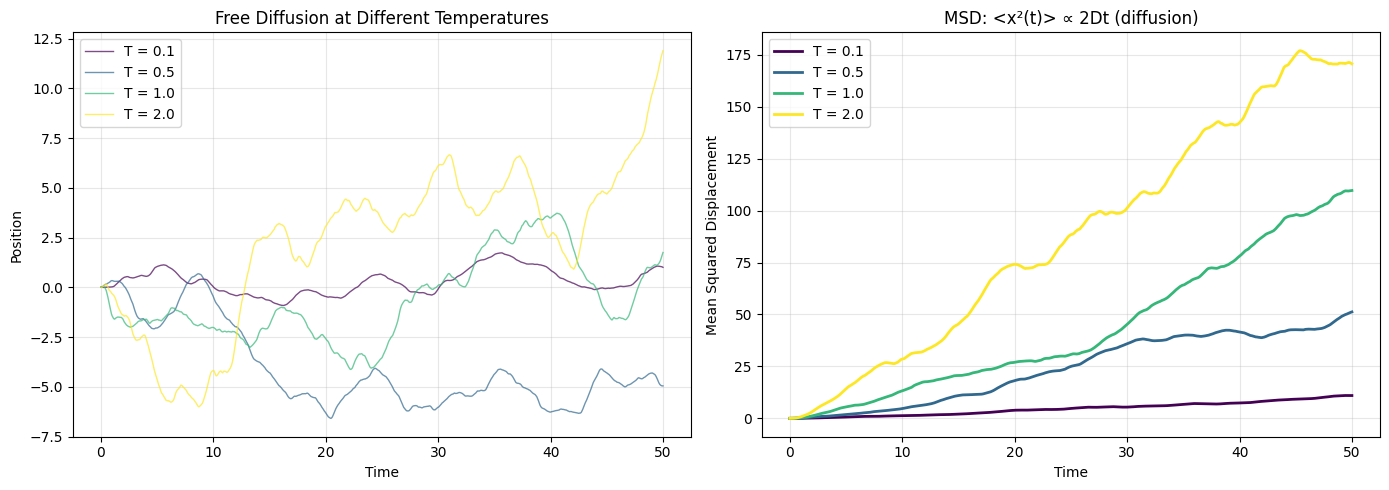

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n_steps = 5000
dt = 0.01
time = np.arange(n_steps) * dt

temperatures = [0.1, 0.5, 1.0, 2.0]
colors = plt.cm.viridis(np.linspace(0, 1, len(temperatures)))

# Free diffusion (no external force)
for temp, color in zip(temperatures, colors):
    sim = LangevinSimulator(mass=1.0, gamma=1.0, temperature=temp, dt=dt)
    x, v = sim.simulate(n_steps, x0=0.0, force_func=lambda x: 0.0)
    axes[0].plot(time, x, linewidth=1, alpha=0.7, color=color,
                label=f'T = {temp}')

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Position')
axes[0].set_title('Free Diffusion at Different Temperatures')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mean squared displacement
n_trajectories = 50
for temp, color in zip(temperatures, colors):
    msd = np.zeros(n_steps)
    sim = LangevinSimulator(mass=1.0, gamma=1.0, temperature=temp, dt=dt)

    for _ in range(n_trajectories):
        x, v = sim.simulate(n_steps, x0=0.0, force_func=lambda x: 0.0)
        msd += x**2

    msd /= n_trajectories
    axes[1].plot(time, msd, linewidth=2, color=color, label=f'T = {temp}')

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Mean Squared Displacement')
axes[1].set_title('MSD: <x²(t)> ∝ 2Dt (diffusion)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# in context of cell

In [142]:
class CellFateModel:
    """
    Stochastic model for cell fate decisions using Langevin dynamics.
    Models gene regulatory networks with noise in gene expression.

    The model: dx/dt = -∇U(x) + ξ(t)
    where U(x) is the potential landscape and ξ represents gene expression noise
    """

    def __init__(self, noise_strength=0.5, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    def bistable_potential(self, x, a=1.0, b=0.25):
        """
        Bistable potential representing two stable cell fates.
        U(x) = -0.5*a*x² + 0.25*b*x⁴
        Two minima represent differentiated states (e.g., neuron vs glia)
        """
        return -0.5 * a * x**2 + 0.25 * b * x**4

    def bistable_force(self, x, a=1.0, b=0.25):
        """Gradient of bistable potential: F = -dU/dx = ax - bx³"""
        return a * x - b * x**3

    def tristable_potential(self, x, y):
        """
        2D potential landscape with three stable states.
        Models scenarios like: stem cell -> (progenitor) -> two differentiated types
        """
        U = -3*x**2 - 3*y**2 + x**4 + y**4 + 0.5*x**2*y**2
        return U

    def tristable_force(self, state):
        """Gradient of tristable potential"""
        x, y = state
        fx = -6*x + 4*x**3 + x*y**2
        fy = -6*y + 4*y**3 + x**2*y
        return np.array([fx, fy])

    def gene_toggle_switch(self, state, alpha=3.0, beta=3.0, n=4):
        """
        Classic gene regulatory toggle switch (mutual repression).
        Two genes A and B that repress each other.

        dA/dt = α/(1+B^n) - A
        dB/dt = β/(1+A^n) - B
        """
        A, B = state
        dA = alpha / (1 + B**n) - A
        dB = beta / (1 + A**n) - B
        return np.array([dA, dB])

    def simulate_1D(self, n_steps, x0=0.0, force_func=None, **params):
        """Simulate 1D cell fate trajectory"""
        if force_func is None:
            force_func = self.bistable_force

        x = np.zeros(n_steps)
        x[0] = x0

        for i in range(1, n_steps):
            # Deterministic drift
            F = force_func(x[i-1], **params)

            # Gene expression noise (intrinsic + extrinsic)
            noise = np.random.normal(0, self.noise_strength)

            # Update
            x[i] = x[i-1] + F * self.dt + noise * np.sqrt(self.dt)

        return x

    def simulate_2D(self, n_steps, state0=None, force_func=None, **params):
        """Simulate 2D cell fate trajectory (e.g., two master regulators)"""
        if state0 is None:
            state0 = np.array([0.0, 0.0])
        if force_func is None:
            force_func = self.gene_toggle_switch

        states = np.zeros((n_steps, 2))
        states[0] = state0

        for i in range(1, n_steps):
            # Deterministic dynamics
            F = force_func(states[i-1], **params)

            # Correlated noise in gene expression
            noise = np.random.normal(0, self.noise_strength, size=2)

            # Update
            states[i] = states[i-1] + F * self.dt + noise * np.sqrt(self.dt)

            # Keep states positive (gene expression levels)
            states[i] = np.clip(states[i], 0.0, None)

        return states

In [169]:
class CellFateModel:
  '''
  stochastic model for cell fate decision using Langevin dynamics
  model gene regulatory networks with noise in gene expression

  The model: dx/dt = -∇U(x) + ξ(t)
  where:
    U(x) is the potential landsape
    ξ represents gene expression noise
  '''
  def __init__(self, noise_strength=0.5, dt=0.01):
    self.noise_strength = noise_strength
    self.dt = dt

  def gene_toggle_switch(self, state, alpha=3.0, beta=3.0, n=4):
    '''
    classic gene reg toggle switch (mutual repressor)
    dA/dt = α/(1+B^n) - A
    dB/dt = β/(1+A^n) - B
    '''
    A,B = state
    dA = alpha / (1 + B**n) - A
    dB = beta / (1 + A**n) - B
    return np.array([dA, dB])

  # def simulate_2D(self,
  #                 n_steps,
  #                 state0=None,
  #                 force_func=None,
  #                 **params):
  #   '''
  #   simulate 2D cell fate
  #   '''
  #   if state0 is None:
  #     state0 = np.array([0.0, 0.0])
  #   if force_func is None:
  #     force_func = self.gene_toggle_switch

  #   states = np.zeros((n_steps, 2))
  #   states[0] = state0

  #   for i in range(1, n_steps):
  #     # deterministic dynamiucs
  #     F = force_func(states[i-1], **params)

  #     # correlated noise in gene expression
  #     noise = np.random.normal(0, self.noise_strength, size=2)

  #     # update
  #     states[i] = states[i-1] + F * self.dt + noise * np.sqrt(self.dt)

  #     # keep states positives (gene expression levels)
  #     states[i] = np.clip(states[i], 0.0, None)

  #   return states

  def simulate_2D(self, n_steps, state0=None, force_func=None, **params):
    """Simulate 2D cell fate trajectory (e.g., two master regulators)"""
    if state0 is None:
        state0 = np.array([0.0, 0.0])
    if force_func is None:
        force_func = self.gene_toggle_switch

    states = np.zeros((n_steps, 2))
    states[0] = state0

    for i in range(1, n_steps):
        # Deterministic dynamics
        F = force_func(states[i-1], **params)

        # Correlated noise in gene expression
        noise = np.random.normal(0, self.noise_strength, size=2)

        # Update
        states[i] = states[i-1] + F * self.dt + noise * np.sqrt(self.dt)

        # Keep states positive (gene expression levels)
        states[i] = np.clip(states[i], 0.0, None)

    return states


In [176]:
A_range = np.linspace(0, 4, 30)
print(A_range)
B_range = np.linspace(0, 4, 30)
print(B_range)

[0.         0.13793103 0.27586207 0.4137931  0.55172414 0.68965517
 0.82758621 0.96551724 1.10344828 1.24137931 1.37931034 1.51724138
 1.65517241 1.79310345 1.93103448 2.06896552 2.20689655 2.34482759
 2.48275862 2.62068966 2.75862069 2.89655172 3.03448276 3.17241379
 3.31034483 3.44827586 3.5862069  3.72413793 3.86206897 4.        ]
[0.         0.13793103 0.27586207 0.4137931  0.55172414 0.68965517
 0.82758621 0.96551724 1.10344828 1.24137931 1.37931034 1.51724138
 1.65517241 1.79310345 1.93103448 2.06896552 2.20689655 2.34482759
 2.48275862 2.62068966 2.75862069 2.89655172 3.03448276 3.17241379
 3.31034483 3.44827586 3.5862069  3.72413793 3.86206897 4.        ]


In [178]:
A_grid, B_grid = np.meshgrid(A_range, B_range)
A_grid

array([[0.        , 0.13793103, 0.27586207, 0.4137931 , 0.55172414,
        0.68965517, 0.82758621, 0.96551724, 1.10344828, 1.24137931,
        1.37931034, 1.51724138, 1.65517241, 1.79310345, 1.93103448,
        2.06896552, 2.20689655, 2.34482759, 2.48275862, 2.62068966,
        2.75862069, 2.89655172, 3.03448276, 3.17241379, 3.31034483,
        3.44827586, 3.5862069 , 3.72413793, 3.86206897, 4.        ],
       [0.        , 0.13793103, 0.27586207, 0.4137931 , 0.55172414,
        0.68965517, 0.82758621, 0.96551724, 1.10344828, 1.24137931,
        1.37931034, 1.51724138, 1.65517241, 1.79310345, 1.93103448,
        2.06896552, 2.20689655, 2.34482759, 2.48275862, 2.62068966,
        2.75862069, 2.89655172, 3.03448276, 3.17241379, 3.31034483,
        3.44827586, 3.5862069 , 3.72413793, 3.86206897, 4.        ],
       [0.        , 0.13793103, 0.27586207, 0.4137931 , 0.55172414,
        0.68965517, 0.82758621, 0.96551724, 1.10344828, 1.24137931,
        1.37931034, 1.51724138, 1.65517241, 1.

(0.0, 4.0)

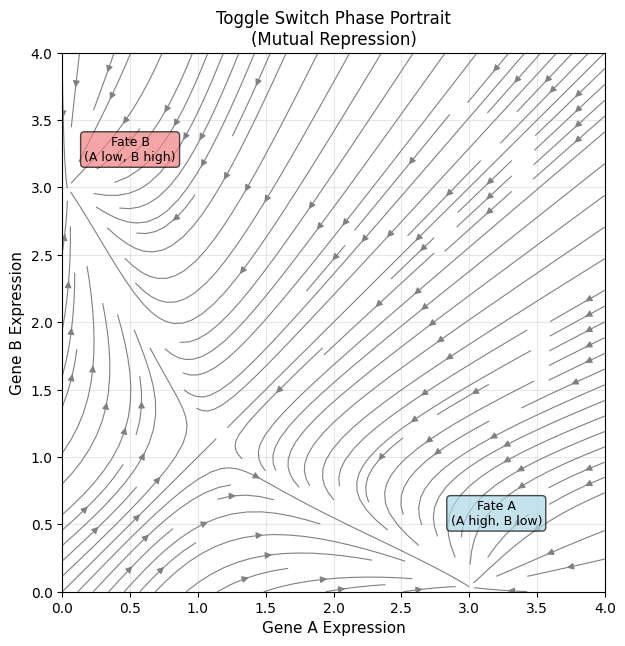

In [180]:
fig = plt.figure(figsize=(7, 7))


A_range = np.linspace(0, 4, 30)
B_range = np.linspace(0, 4, 30)
A_grid, B_grid = np.meshgrid(A_range, B_range)

model = CellFateModel(noise_strength=0.0, dt=0.01)

# Calculate vector field
dA = np.zeros_like(A_grid)
dB = np.zeros_like(B_grid)

# for i in range(len(A_range)):
#     for j in range(len(B_range)):
#         state = np.array([A_grid[j, i], B_grid[j, i]])
#         F = model.gene_toggle_switch(state, alpha=3.0, beta=3.0, n=4)
#         dA[j, i] = F[0]
#         dB[j, i] = F[1]

states = np.stack([A_grid, B_grid], axis=-1)  # shape: (30, 30, 2)
F = np.zeros_like(states)

for j in range(states.shape[0]):
    for i in range(states.shape[1]):
        F[j, i] = model.gene_toggle_switch(states[j, i], alpha=3.0, beta=3.0, n=4)

dA = F[:, :, 0]
dB = F[:, :, 1]

# Plot streamlines
plt.streamplot(A_grid, B_grid, dA, dB, color='gray', density=1.2, linewidth=0.8)
plt.xlabel('Gene A Expression', fontsize=11)
plt.ylabel('Gene B Expression', fontsize=11)
plt.title('Toggle Switch Phase Portrait\n(Mutual Repression)', fontsize=12)
plt.text(3.2, 0.5, 'Fate A\n(A high, B low)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
plt.text(0.5, 3.2, 'Fate B\n(A low, B high)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
plt.grid(True, alpha=0.3)
plt.xlim(0, 4)
plt.ylim(0, 4)


(0.0, 4.0)

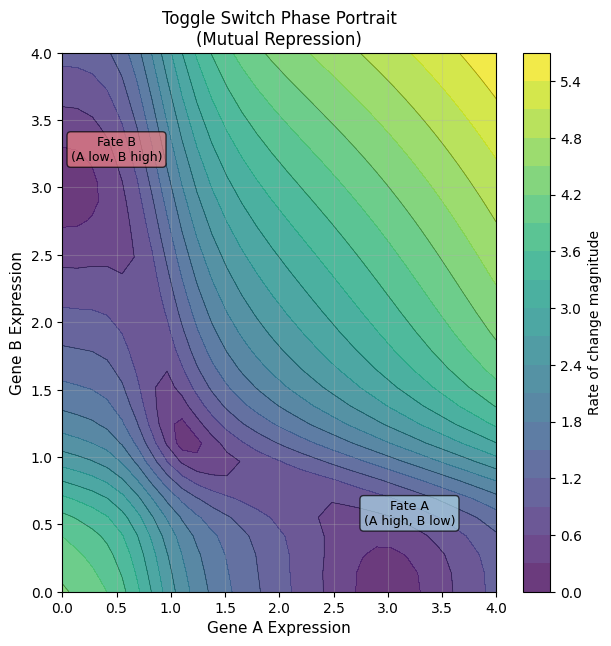

In [179]:
fig = plt.figure(figsize=(7, 7))

A_range = np.linspace(0, 4, 30)
B_range = np.linspace(0, 4, 30)
A_grid, B_grid = np.meshgrid(A_range, B_range)

model = CellFateModel(noise_strength=0.0, dt=0.01)

# Calculate vector field
dA = np.zeros_like(A_grid)
dB = np.zeros_like(B_grid)

for i in range(len(A_range)):
    for j in range(len(B_range)):
        state = np.array([A_grid[j, i], B_grid[j, i]])
        F = model.gene_toggle_switch(state, alpha=3.0, beta=3.0, n=4)
        dA[j, i] = F[0]
        dB[j, i] = F[1]

# Calculate magnitude of vector field for contours
magnitude = np.sqrt(dA**2 + dB**2)

# Plot contour
contour = plt.contourf(A_grid, B_grid, magnitude, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, label='Rate of change magnitude')

# Optionally add contour lines
plt.contour(A_grid, B_grid, magnitude, levels=10, colors='black', linewidths=0.5, alpha=0.4)

plt.xlabel('Gene A Expression', fontsize=11)
plt.ylabel('Gene B Expression', fontsize=11)
plt.title('Toggle Switch Phase Portrait\n(Mutual Repression)', fontsize=12)
plt.text(3.2, 0.5, 'Fate A\n(A high, B low)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
plt.text(0.5, 3.2, 'Fate B\n(A low, B high)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
plt.grid(True, alpha=0.3)
plt.xlim(0, 4)
plt.ylim(0, 4)

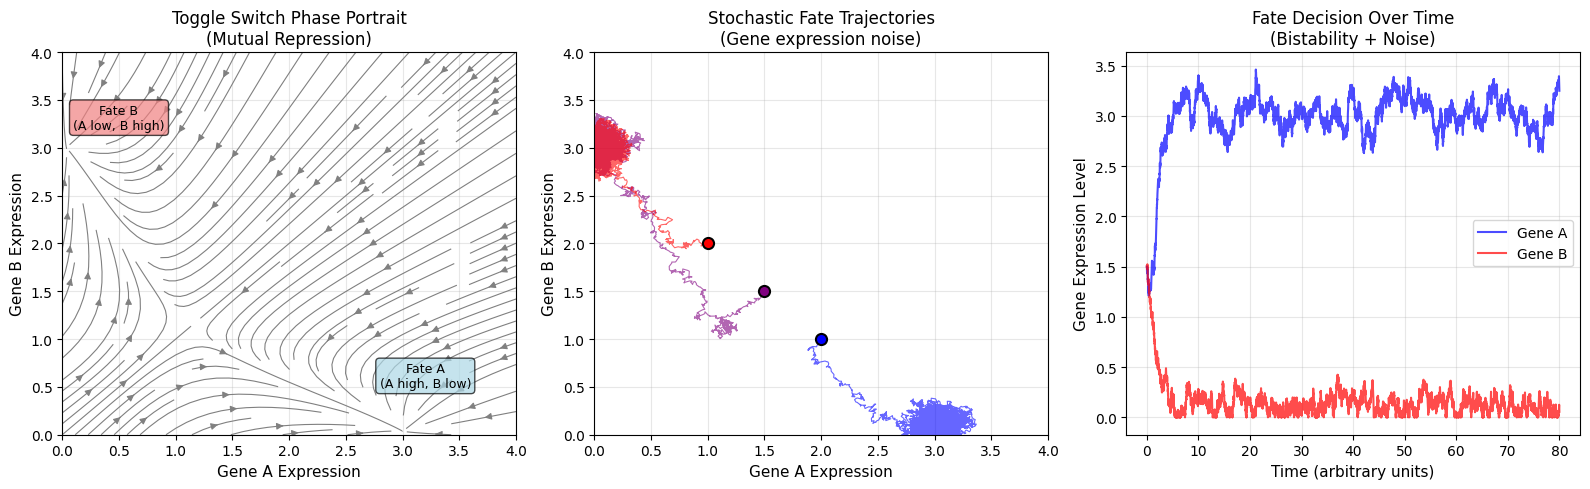

In [170]:
fig = plt.figure(figsize=(16, 5))

# Subplot 1: Phase portrait with nullclines
ax1 = plt.subplot(131)

A_range = np.linspace(0, 4, 30)
B_range = np.linspace(0, 4, 30)
A_grid, B_grid = np.meshgrid(A_range, B_range)

model = CellFateModel(noise_strength=0.0, dt=0.01)

# Calculate vector field
dA = np.zeros_like(A_grid)
dB = np.zeros_like(B_grid)

for i in range(len(A_range)):
    for j in range(len(B_range)):
        state = np.array([A_grid[j, i], B_grid[j, i]])
        F = model.gene_toggle_switch(state, alpha=3.0, beta=3.0, n=4)
        dA[j, i] = F[0]
        dB[j, i] = F[1]

# Plot streamlines
ax1.streamplot(A_grid, B_grid, dA, dB, color='gray', density=1.2, linewidth=0.8)
ax1.set_xlabel('Gene A Expression', fontsize=11)
ax1.set_ylabel('Gene B Expression', fontsize=11)
ax1.set_title('Toggle Switch Phase Portrait\n(Mutual Repression)', fontsize=12)
ax1.text(3.2, 0.5, 'Fate A\n(A high, B low)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
ax1.text(0.5, 3.2, 'Fate B\n(A low, B high)', ha='center', fontsize=9,
          bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 4)
ax1.set_ylim(0, 4)

# Subplot 2: Stochastic trajectories
ax2 = plt.subplot(132)

model_stoch = CellFateModel(noise_strength=0.15, dt=0.01)
n_steps = 10000

initial_states = [
    np.array([1.5, 1.5]),  # Near unstable point
    np.array([2.0, 1.0]),
    np.array([1.0, 2.0])
]
colors = ['purple', 'blue', 'red']

for state0, color in zip(initial_states, colors):
    traj = model_stoch.simulate_2D(n_steps, state0=state0)
    ax2.plot(traj[:, 0], traj[:, 1], linewidth=0.8, alpha=0.6, color=color)
    ax2.plot(state0[0], state0[1], 'o', markersize=8, color=color,
            markeredgecolor='black', markeredgewidth=1.5)

ax2.set_xlabel('Gene A Expression', fontsize=11)
ax2.set_ylabel('Gene B Expression', fontsize=11)
ax2.set_title('Stochastic Fate Trajectories\n(Gene expression noise)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 4)
ax2.set_ylim(0, 4)

# Subplot 3: Time series for one trajectory
ax3 = plt.subplot(133)

model_ts = CellFateModel(noise_strength=0.2, dt=0.01)
n_steps = 8000
time = np.arange(n_steps) * 0.01

traj = model_ts.simulate_2D(n_steps, state0=np.array([1.5, 1.5]))

ax3.plot(time, traj[:, 0], linewidth=1.5, alpha=0.7, label='Gene A', color='blue')
ax3.plot(time, traj[:, 1], linewidth=1.5, alpha=0.7, label='Gene B', color='red')
ax3.set_xlabel('Time (arbitrary units)', fontsize=11)
ax3.set_ylabel('Gene Expression Level', fontsize=11)
ax3.set_title('Fate Decision Over Time\n(Bistability + Noise)', fontsize=12)
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [167]:
class CellFateModel:
    """
    Stochastic model for cell fate decisions using Langevin dynamics.
    Models gene regulatory networks with noise in gene expression.

    The model: dx/dt = -∇U(x) + ξ(t)
    where U(x) is the potential landscape and ξ represents gene expression noise
    """

    def __init__(self, noise_strength=0.5, dt=0.01):
        self.noise_strength = noise_strength
        self.dt = dt

    # def bistable_potential(self, x, a=1.0, b=0.25):
    #     """
    #     Bistable potential representing two stable cell fates.
    #     U(x) = -0.5*a*x² + 0.25*b*x⁴
    #     Two minima represent differentiated states (e.g., neuron vs glia)
    #     """
    #     return -0.5 * a * x**2 + 0.25 * b * x**4

    # def bistable_force(self, x, a=1.0, b=0.25):
    #     """Gradient of bistable potential: F = -dU/dx = ax - bx³"""
    #     return a * x - b * x**3

    # def tristable_potential(self, x, y):
    #     """
    #     2D potential landscape with three stable states.
    #     Models scenarios like: stem cell -> (progenitor) -> two differentiated types
    #     """
    #     U = -3*x**2 - 3*y**2 + x**4 + y**4 + 0.5*x**2*y**2
    #     return U

    # def tristable_force(self, state):
    #     """Gradient of tristable potential"""
    #     x, y = state
    #     fx = -6*x + 4*x**3 + x*y**2
    #     fy = -6*y + 4*y**3 + x**2*y
    #     return np.array([fx, fy])

    def gene_toggle_switch(self, state, alpha=3.0, beta=3.0, n=4):
        """
        Classic gene regulatory toggle switch (mutual repression).
        Two genes A and B that repress each other.

        dA/dt = α/(1+B^n) - A
        dB/dt = β/(1+A^n) - B
        """
        A, B = state
        dA = alpha / (1 + B**n) - A
        dB = beta / (1 + A**n) - B
        return np.array([dA, dB])

    # def simulate_1D(self, n_steps, x0=0.0, force_func=None, **params):
    #     """Simulate 1D cell fate trajectory"""
    #     if force_func is None:
    #         force_func = self.bistable_force

    #     x = np.zeros(n_steps)
    #     x[0] = x0

    #     for i in range(1, n_steps):
    #         # Deterministic drift
    #         F = force_func(x[i-1], **params)

    #         # Gene expression noise (intrinsic + extrinsic)
    #         noise = np.random.normal(0, self.noise_strength)

    #         # Update
    #         x[i] = x[i-1] + F * self.dt + noise * np.sqrt(self.dt)

    #     return x

    def simulate_2D(self, n_steps, state0=None, force_func=None, **params):
        """Simulate 2D cell fate trajectory (e.g., two master regulators)"""
        if state0 is None:
            state0 = np.array([0.0, 0.0])
        if force_func is None:
            force_func = self.gene_toggle_switch

        states = np.zeros((n_steps, 2))
        states[0] = state0

        for i in range(1, n_steps):
            # Deterministic dynamics
            F = force_func(states[i-1], **params)

            # Correlated noise in gene expression
            noise = np.random.normal(0, self.noise_strength, size=2)

            # Update
            states[i] = states[i-1] + F * self.dt + noise * np.sqrt(self.dt)

            # Keep states positive (gene expression levels)
            states[i] = np.clip(states[i], 0.0, None)

        return states

